In [17]:
import numpy as np 
import pandas as pd 

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv1D,GlobalMaxPooling1D, Dropout, Flatten
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

In [2]:
dataset = pd.read_csv('convertcsv.csv')
data = dataset[['text','aspectCategories/aspectCategory/0/_polarity']]
#data = dataset.rename(index=str, columns={ 0: "text", 6: "sentiment"})
newdata = data.dropna()
newdata.isnull().sum()
newdata = newdata.rename(columns={'aspectCategories/aspectCategory/0/_polarity': 'sentiment'})

In [3]:
newdata['text'] = newdata['text'].apply(lambda x: x.lower())
print(newdata[ newdata['sentiment'] == 'positive'].size)
print(newdata[ newdata['sentiment'] == 'negative'].size)
print(newdata[ newdata['sentiment'] == 'neutral'].size)
print(newdata[ newdata['sentiment'] == 'conflict'].size)
newdata = newdata[newdata.sentiment != "conflict"]
newdata = newdata[newdata.sentiment != "neutral"]
newdata.head(5)

3484
1316
954
334


,text,sentiment
0,but the staff was so horrible to us.,negative
1,"to be completely fair, the only redeeming fact...",positive
2,"the food is uniformly exceptional, with a very...",positive
3,where gabriela personaly greets you and recomm...,positive
4,"for those that go once and don't enjoy it, all...",positive


In [4]:
#Make number of classes balanced 
num_of_categories = 700
shuffled = newdata.reindex(np.random.permutation(newdata.index))
po = shuffled[shuffled['sentiment'] == 'positive'][:num_of_categories]
ng = shuffled[shuffled['sentiment'] == 'negative'][:num_of_categories]

concated = pd.concat([po,ng], ignore_index=True)
#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
print(concated.size)

print(concated[ concated['sentiment'] == 'positive'].size)
print(concated[ concated['sentiment'] == 'negative'].size)


2716
1400
1316


In [6]:
max_fatures = 6000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(concated['text'].values)
X = tokenizer.texts_to_sequences(concated['text'].values)
X = pad_sequences(X)

import pickle
# saving
with open('review_token_lstm.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
embedding_dim = 128
model = Sequential()
model.add(Embedding(max_fatures, embedding_dim, input_length = X.shape[1]))
model.add(Conv1D(128, 5, activation='relu'))
model.add(Dropout(0.2))
model.add(GlobalMaxPooling1D())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2,activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 69, 128)           768000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 128)           82048     
_________________________________________________________________
dropout_2 (Dropout)          (None, 65, 128)           0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 22        
Total para

In [19]:
Y = pd.get_dummies(concated['sentiment']).values
print(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

[[1 0]
 [1 0]
 [1 0]
 ...
 [1 0]
 [1 0]
 [0 1]]
(1086, 69) (1086, 2)
(272, 69) (272, 2)


In [20]:
batch_size = 32
sentiment_model = model.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs = 10, batch_size=batch_size, verbose = 2)

Train on 1086 samples, validate on 272 samples
Epoch 1/10
 - 2s - loss: 0.6910 - acc: 0.5226 - val_loss: 0.6817 - val_acc: 0.5956
Epoch 2/10
 - 1s - loss: 0.6456 - acc: 0.6722 - val_loss: 0.6368 - val_acc: 0.7132
Epoch 3/10
 - 1s - loss: 0.5067 - acc: 0.8158 - val_loss: 0.5423 - val_acc: 0.7592
Epoch 4/10
 - 1s - loss: 0.3213 - acc: 0.8665 - val_loss: 0.4554 - val_acc: 0.7923
Epoch 5/10
 - 1s - loss: 0.1822 - acc: 0.9259 - val_loss: 0.4769 - val_acc: 0.8070
Epoch 6/10
 - 1s - loss: 0.1195 - acc: 0.9710 - val_loss: 0.5168 - val_acc: 0.8033
Epoch 7/10
 - 1s - loss: 0.0768 - acc: 0.9880 - val_loss: 0.5622 - val_acc: 0.8015
Epoch 8/10
 - 1s - loss: 0.0607 - acc: 0.9899 - val_loss: 0.6303 - val_acc: 0.7849
Epoch 9/10
 - 1s - loss: 0.0447 - acc: 0.9959 - val_loss: 0.6821 - val_acc: 0.7812
Epoch 10/10
 - 1s - loss: 0.0472 - acc: 0.9936 - val_loss: 0.7082 - val_acc: 0.7941


<Figure size 432x288 with 0 Axes>

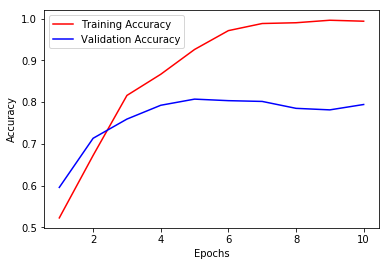

<Figure size 432x288 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt
acc = sentiment_model.history['acc']
val_acc = sentiment_model.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, color = 'red', label='Training acc')
plt.plot(epochs, val_acc, color = 'blue', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy','Validation Accuracy'])

plt.figure()

In [22]:
y_predict = model.predict(X_test)
y_test_non_category = [ np.argmax(t) for t in Y_test ]
y_predict_non_category = [ np.argmax(t) for t in y_predict ]

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
print(conf_mat)

true_pos = np.diag(conf_mat) 
precision = true_pos / np.sum(conf_mat, axis=0)
recall = true_pos / np.sum(conf_mat, axis=1)
mean_recall = np.mean(recall)
mean_precision = np.mean(precision)
mean_f1 = 2 * (mean_precision * mean_recall) / (mean_precision + mean_recall)
print(mean_recall)
print(mean_precision)
print(mean_f1)

[[ 86  32]
 [ 25 129]]
0.7832379484921858
0.7880085053998097
0.7856159848570332


In [24]:
review = ["Lacks diversity in workforce"]
#vectorizing the tweet by the pre-fitted tokenizer instance
review = tokenizer.texts_to_sequences(review)
#padding the tweet to have exactly the same shape as `embedding_2` input
review = pad_sequences(review, maxlen=69, dtype='int32', value=0)
#print(review)
sentiment = model.predict(review,batch_size=1,verbose = 2)[0]
print(sentiment)
score = np.max(sentiment)
print(score)
position = np.argmax(sentiment)
if position == 0 and score > 0.55:
    print('negative')
elif position == 1 and score > 0.55:
    print('positive')
elif position == 0 or position == 1 and score >= 0.45 and score <=0.55:
    print('neutral')

[0.3887798 0.5021198]
0.5021198
neutral


In [38]:
from keras.models import load_model

model.save('sentiment_model_lstm_large.h5')